In [79]:
from blockciphers import aes_image_encryption, aes_mcs_diffusion, aes_mcs_confusion
from Crypto.Cipher import AES
import os
from matplotlib.image import imread, imsave
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import hamming

## AES

In [80]:
# Open the PNG image
image_path = 'image.png'

# Generate a random 128 bits key
random_key = os.urandom(16)

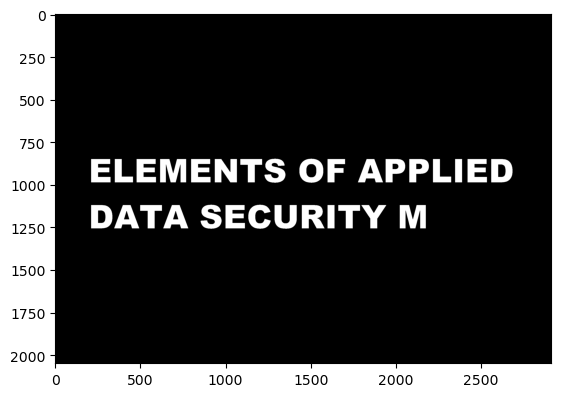

In [81]:
image = imread(image_path).mean(axis=-1)
image = 255 * image.astype(np.uint8)
plt.imshow(image, cmap='gray');

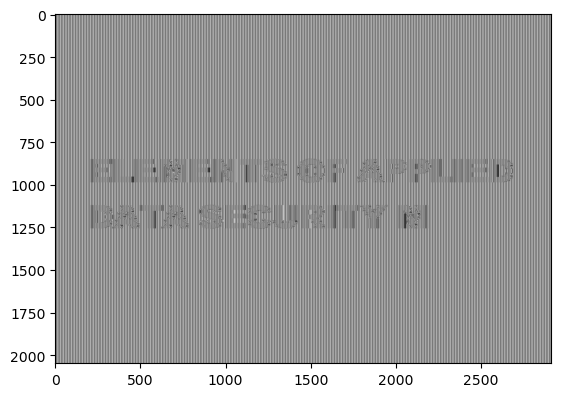

In [82]:
# Instantiate AES with ECB mode of operation
aes_ecb = AES.new(random_key, AES.MODE_ECB)
# Encrypt the image
aes_image_encryption(aes_ecb, 'ECB', image)

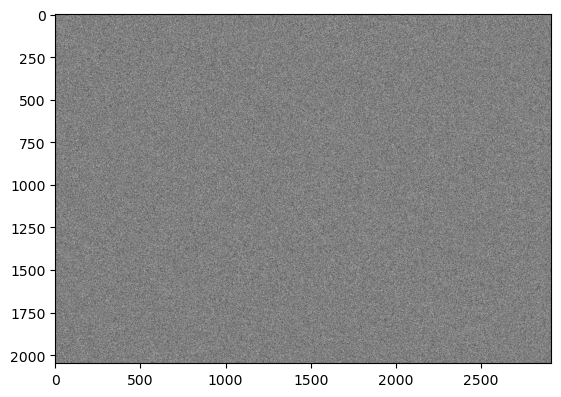

In [83]:
# Instantiate AES with CBC mode of operation
aes_cbc = AES.new(random_key, AES.MODE_CBC)
# Encrypt the image
aes_image_encryption(aes_cbc, 'CBC', image)

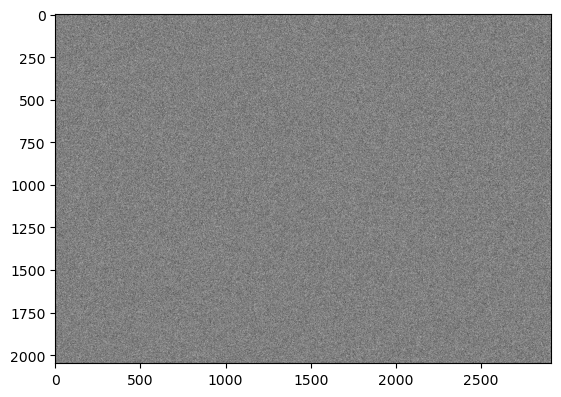

In [84]:
# Instantiate AES with CFB mode of operation
aes_cfb= AES.new(random_key, AES.MODE_CFB)
# Encrypt the image
aes_image_encryption(aes_cfb, 'CFB', image)

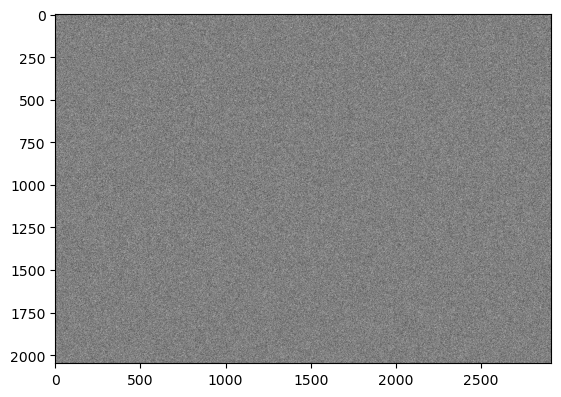

In [85]:
# Instantiate AES with CTR mode of operation
aes_ctr = AES.new(random_key, AES.MODE_CTR)
# Encrypt the image
aes_image_encryption(aes_ctr, 'CTR', image)

## Monte Carlo Simulation

### $\pi$ estimation


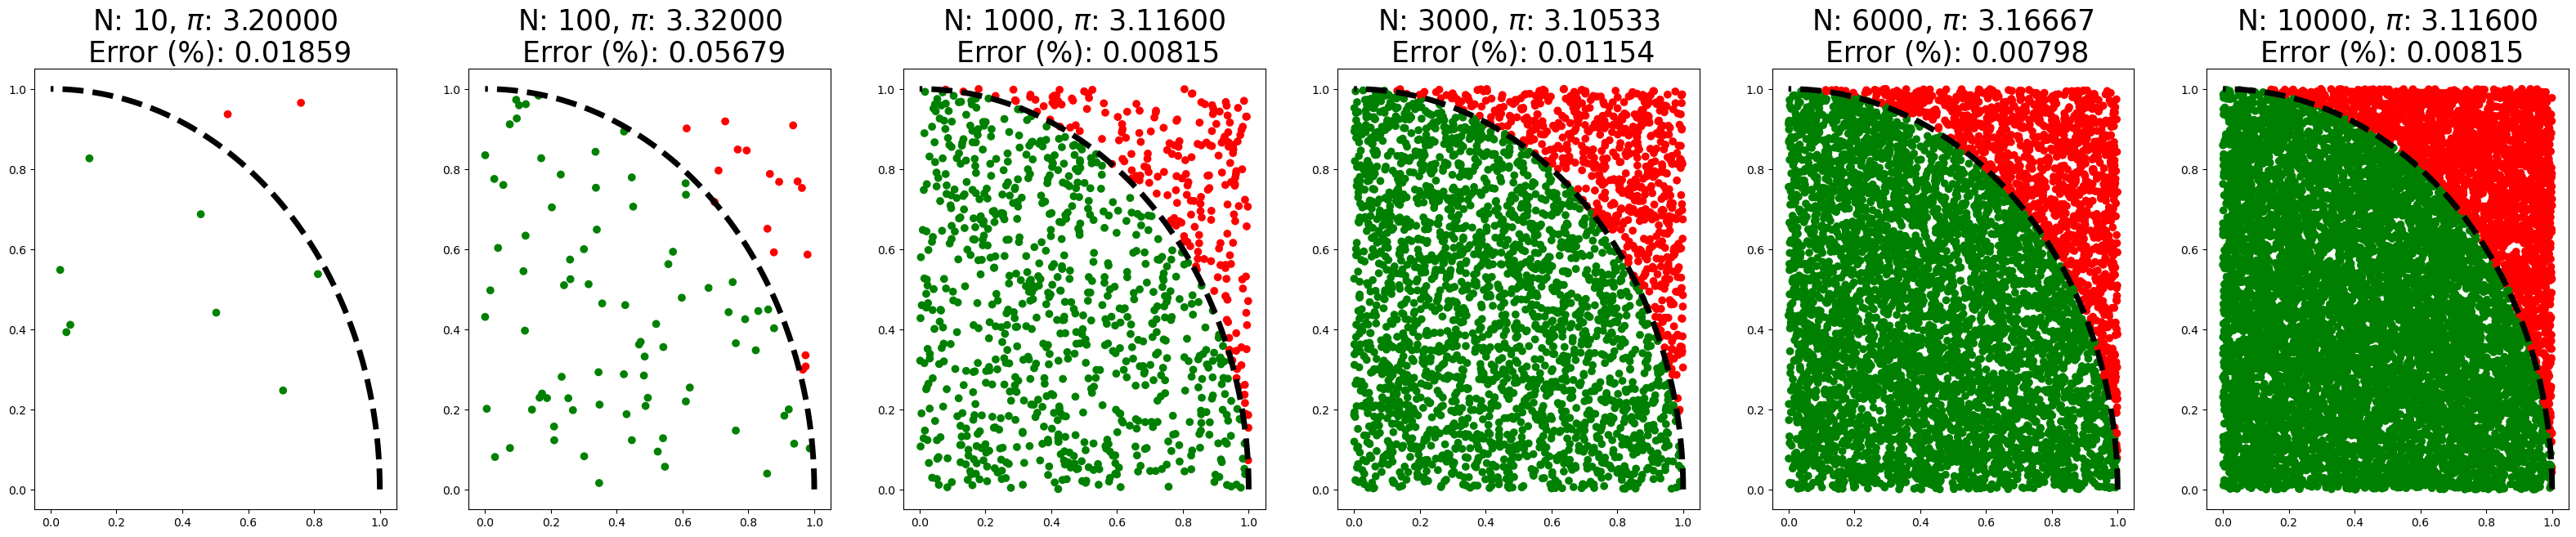

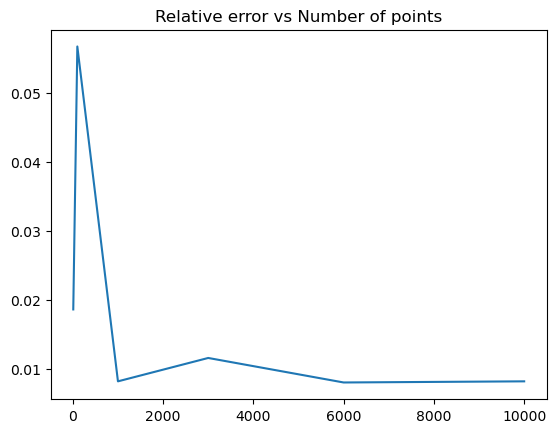

In [86]:
n_points = [10, 100, 1000, 3000, 6000, 10000]

fig1, axs1 = plt.subplots(1, len(n_points), figsize=(40, 7))

# Points to plot the quarter of circle
theta = np.linspace(0, np.pi/2, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)

# Lists containg the pi estimations and the respective relative errors
pi_est = []
err = []
for a, n in enumerate(n_points):
    # Number of points falling inside the circle
    circle_points = 0
    colors = []
    # Randomly drawn points coordinates
    x_coord = np.random.rand(n)
    y_coord = np.random.rand(n)
    #Counting how many points are inside the circle
    for x, y in zip(x_coord, y_coord):
        if np.linalg.norm((x, y)) <= 1:
            colors.append('green')
            circle_points += 1
        else:
            colors.append('red')

    # Compute pi estimation and respective relative error       
    pi_est.append(4*circle_points/n)
    err.append(np.abs(pi_est[a] - np.pi)/np.pi)

    axs1[a].scatter(x_coord, y_coord, c=colors)
    axs1[a].plot(x_circle, y_circle, linestyle='--', linewidth=5, color='black')
    axs1[a].set_title(f'N: {n}, $\pi$: {pi_est[a]:.5f}\n Error (%): {err[a]:.5f}', fontsize = 25)

plt.figure()
plt.plot(n_points, err)
plt.title('Relative error vs Number of points');

## AES Diffusion and Confusion

ECB Mode of OPeration is uses since it offers a more "direct" relation between plaintext-key and ciphertext

### Diffusion evaluation

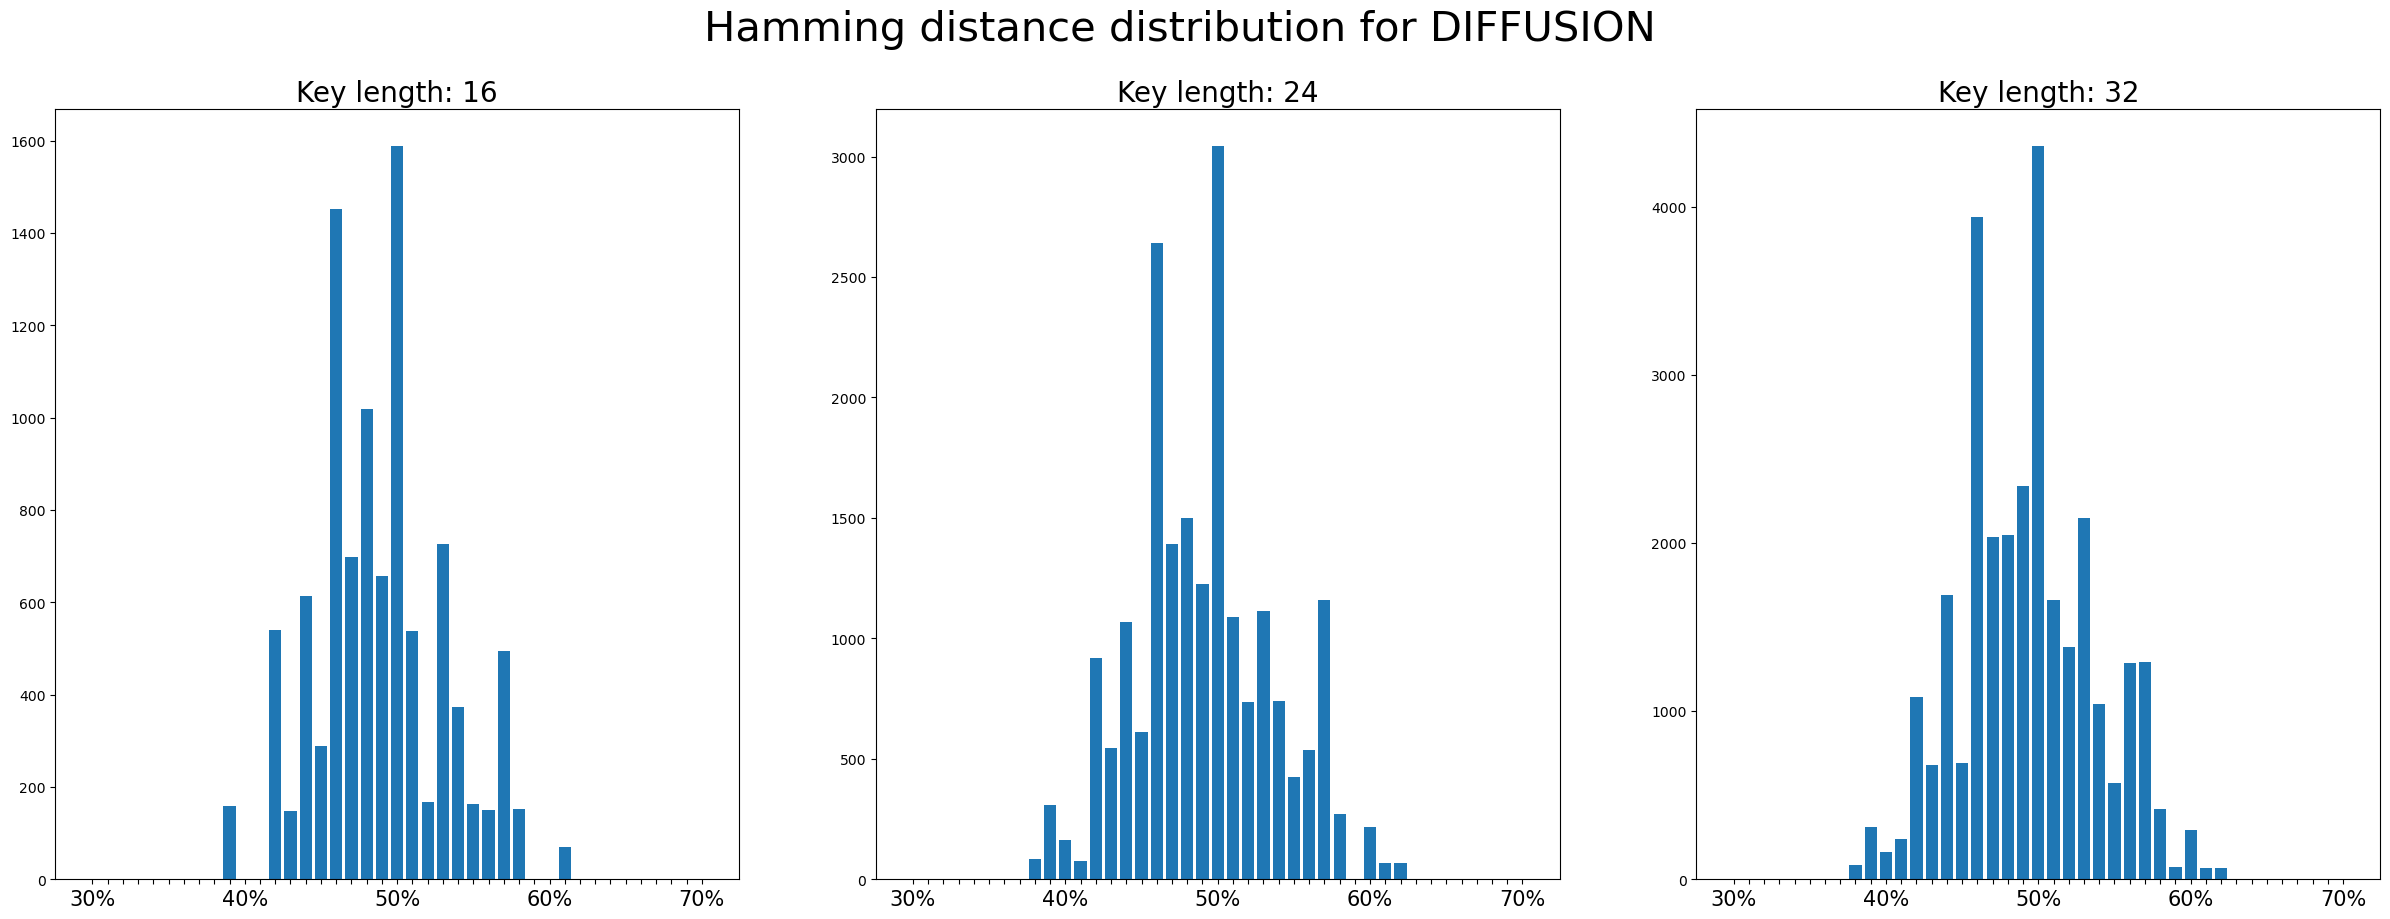

In [87]:
import os
import matplotlib.pyplot as plt
from Crypto.Cipher import AES

iterations = 10000
fig, axs = plt.subplots(1, len(AES.key_size), figsize=(30, 10))
fig.suptitle('Hamming distance distribution for DIFFUSION', fontsize=30)

# Dictionary for the hamming distance distribution
diff_dict = {f"{i}%": 0 for i in range(30, 71)}
x_labels = diff_dict.keys()
x_ticks = range(0, len(x_labels))

for idx, length in enumerate(AES.key_size):
    # Generate random key of 16, 24 or 32 bytes
    key = os.urandom(length)
    # Instantiate AES cipher
    aes_ecb = AES.new(key, AES.MODE_ECB)
    # Generate a random 128 bits plaintext
    ref_plaintext = os.urandom(AES.block_size)
    # Encrypt the plaintext
    ref_ciphertext = bytearray(aes_ecb.encrypt(ref_plaintext))

    # Compute the list of hamming distances (as %) comparing the original
    # ciphertext with the ones obtained flipping a random bit in the plaintext
    dist = aes_mcs_diffusion(aes_ecb, ref_plaintext, ref_ciphertext, iterations)

    # Counting how many outcomes per percentage
    for value in dist:
        for i in range(30, 71):
            if i <= value < i + 1:
                diff_dict[f"{i}%"] += 1
                break

    axs[idx].bar(range(len(x_labels)), diff_dict.values())
    axs[idx].set_title(f'Key length: {length}', fontsize=20)
    axs[idx].set_xticks(x_ticks)
    axs[idx].set_xticklabels(['' if label not in ['30%', '40%', '50%', '60%', '70%'] 
                              else label for label in x_labels], fontsize=15)  # Set subset of labels

plt.show()


### Confusion evaluation

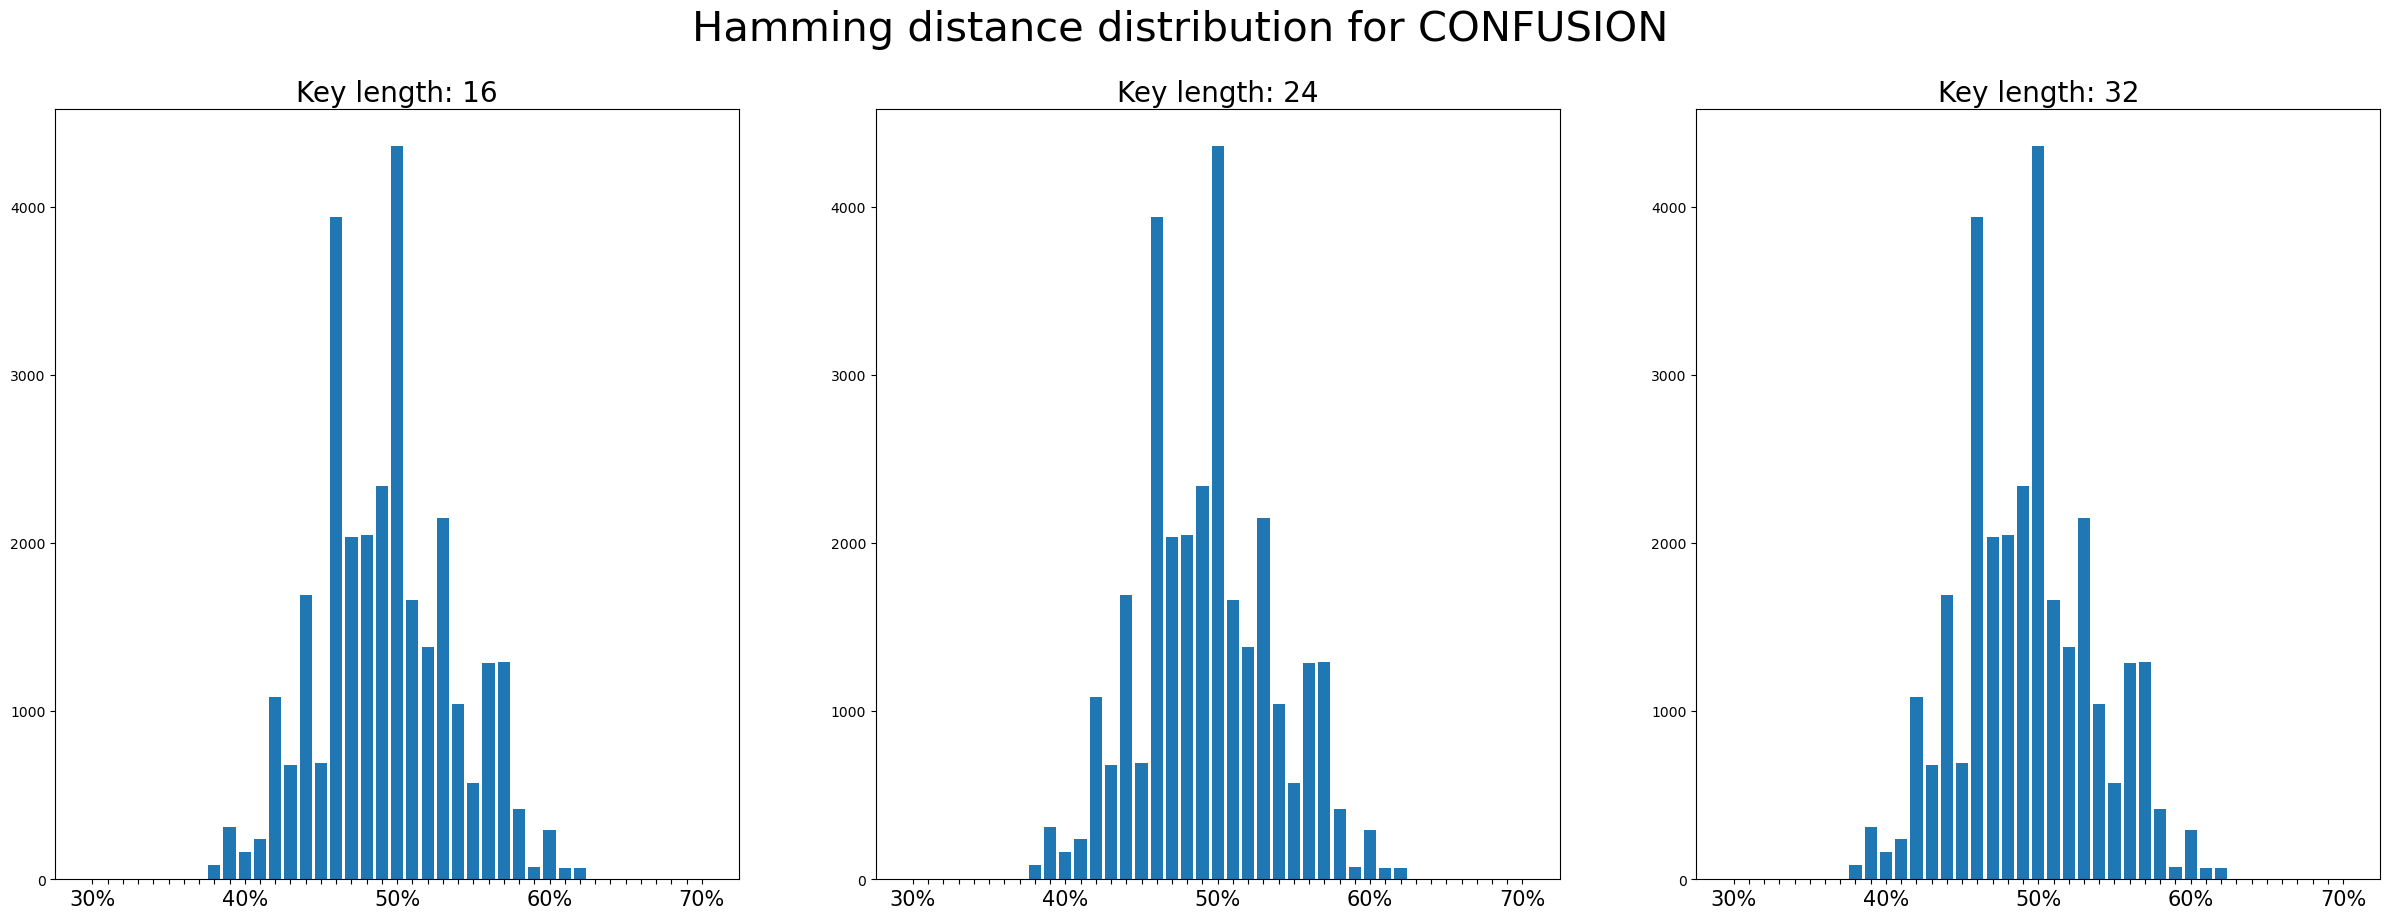

In [88]:
iterations = 10000

fig, axs = plt.subplots(1, len(AES.key_size), figsize=(30, 10))
fig.suptitle('Hamming distance distribution for CONFUSION', fontsize=30)

conf_dict = {f"{i}%": 0 for i in range(30, 71)}

for idx, length in enumerate(AES.key_size):
    # Generate random key of 16, 24 or 32 bytes
    key = os.urandom(length)
    # Generate a random 128 bits plaintext
    ref_plaintext = os.urandom(AES.block_size)
    # Encrypt the plaintext
    ref_ciphertext = bytearray(aes_ecb.encrypt(ref_plaintext))

    # Compute the list of hamming distances (as %) comparing the original
    # ciphertext with the ones obtained flipping a random bit in the key
    dist = aes_mcs_confusion(key, length, ref_plaintext, ref_ciphertext, iterations)

    for value in dist:
        for i in range(30, 71):
            if i <= value < i + 1:
                conf_dict[f"{i}%"] += 1
                break
            
    axs[idx].bar(range(len(x_labels)), diff_dict.values())
    axs[idx].set_title(f'Key length: {length}', fontsize=20)
    axs[idx].set_xticks(x_ticks)
    axs[idx].set_xticklabels(['' if label not in ['30%', '40%', '50%', '60%', '70%'] 
                              else label for label in x_labels], fontsize=15)  # Set subset of labels